<a href="https://colab.research.google.com/github/Boon-Yang/Machine-Learning-for-Defect-Detection-In-Additive-Manufacturing/blob/master/One_Class_Learning(I).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Notebook to G. Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import scipy.io as io
import os 
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import h5py

# Progress bar
from tqdm import tqdm

# Features Extraction
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon
from skimage.measure import regionprops, label
from statistics import mean

os.chdir('/content/drive/My Drive/FYP MAT Data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Import Features

In [ ]:
features_df = pd.read_csv('/content/drive/My Drive/FYP MAT Data/Build1_Features.csv')
features_df.head()

,blockNo,ImageId,spatterNum,spatterArea,spatterEccenticity,blobArea,blobEccentricity
0,1,0,0,0,0.0,0,0.0
1,1,1,0,0,0.0,0,0.0
2,1,2,0,0,0.0,0,0.0
3,1,3,0,0,0.0,0,0.0
4,1,4,0,0,0.0,0,0.0


blobArea


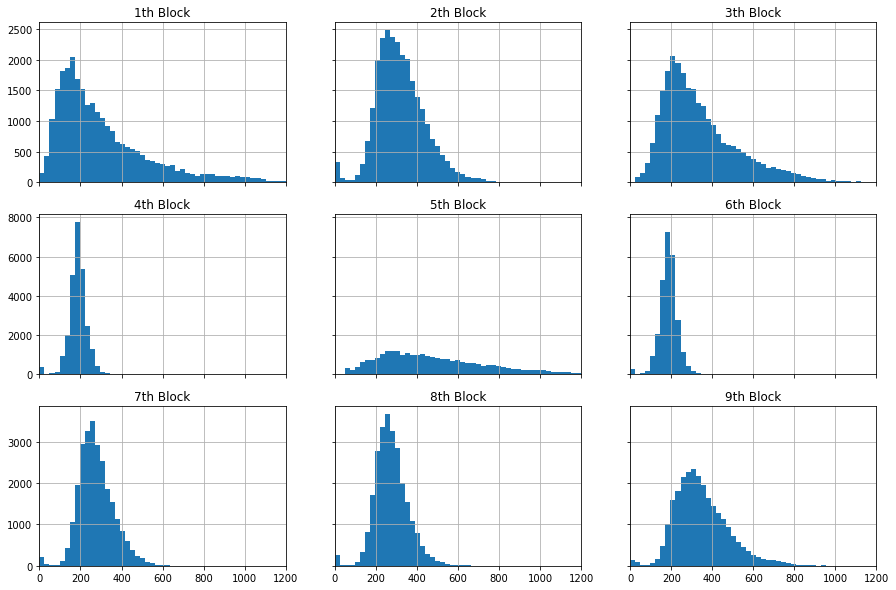

In [ ]:
feature = 'blobArea'

fig, axs =  plt.subplots(3, 3, figsize=(15, 10) , sharex='col', sharey='row')
axs = axs.flatten()

for ix, ax in enumerate(axs):
  ax.hist(features_df.query("blockNo == {}".format(ix+1))[feature], bins=np.linspace(0, 1200, 50))
  ax.set_xlim(0, 1200)
  ax.set_title(str(ix+1) + 'th Block')
  ax.grid()
print(feature)

spatterArea


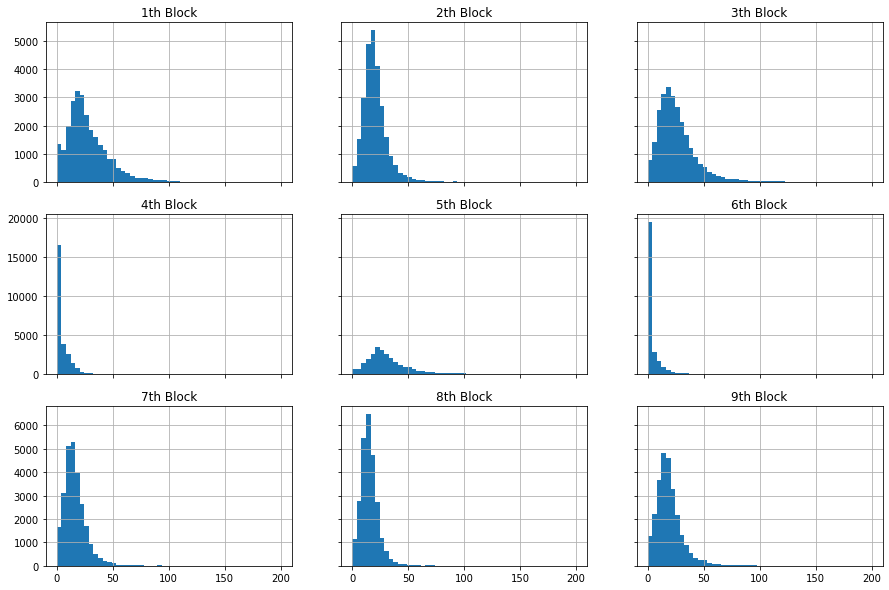

In [ ]:
feature = 'spatterArea'

fig, axs =  plt.subplots(3, 3, figsize=(15, 10) , sharex='col', sharey='row')
axs = axs.flatten()

for ix, ax in enumerate(axs):
  ax.hist(features_df.query("blockNo == {}".format(ix+1))[feature], bins=np.linspace(0, 200, 50))
  ax.set_title(str(ix+1) + 'th Block')
  ax.grid()
print(feature)

4th and 6th blocks have more consistent blob sizes and lots of zero spatter properties. 7th and 8th rank right after 4th and 6th. 

The next step is to filter out anomalous melt pools from focus images.

# Binarizing Data


In [ ]:
features_df['isFocused'] = features_df['blockNo'].apply(lambda x: 1 if (x == 4 or x == 6) else 0 )

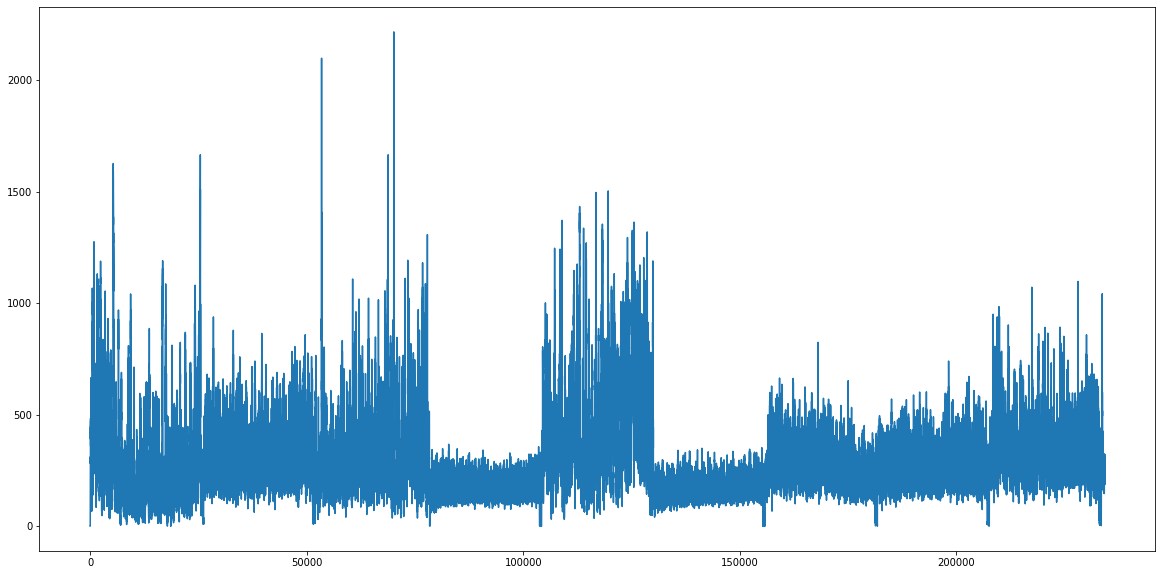

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(features_df['blobArea'])

# K Means Clustering
I labelled all the images from 4nd and 6th as focused and the remaining from 7th and 8th as oof.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [ ]:
def getBlockMetrics(features_df, block_no):
  tem = features_df[features_df['blockNo'] == block_no].copy()
  return tem

In [ ]:
block4Metrics = getBlockMetrics(features_df, 4)
block6Metrics = getBlockMetrics(features_df, 6)
block7Metrics = getBlockMetrics(features_df, 3)
block8Metrics = getBlockMetrics(features_df, 5)

training_df = pd.concat([block4Metrics, block6Metrics, block7Metrics, block8Metrics])
training_df = training_df.reset_index(drop=True)

In [ ]:
training_df.groupby('blockNo')['isFocused'].first()

blockNo
3    0
4    1
5    0
6    1
Name: isFocused, dtype: int64

In [ ]:
X = training_df.drop(columns=['blockNo', 'ImageId', 'isFocused'])

# since kmeans operates based on the Euclidean distances, we need to standardize the dataset
Scaler = StandardScaler()
Scaler.fit(X)
X_scaled = Scaler.transform(X)

In [ ]:
err = []
np.random.seed(42)
K = range(1, 50)
for k in K:
    kmeanModel = MiniBatchKMeans(n_clusters=k, random_state = 42)
    kmeanModel.fit(X_scaled)
    err.append((k,kmeanModel.inertia_))

k = 15 is chosen


(0.0, 49.0)

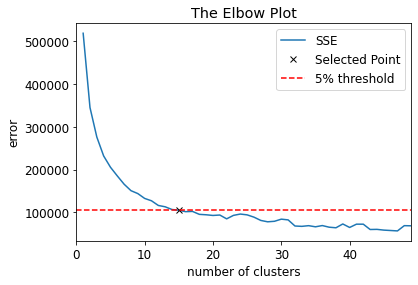

In [ ]:
err_x = [index[0] for index in err]
err_y = [index[1] for index in err]
plt.plot(err_x, err_y, label='SSE');

plt.rcParams.update({'font.size':12})
optimal_k = 15
plt.plot(err_x[optimal_k-1], err_y[optimal_k-1], 'kx', label='Selected Point')
plt.xlabel('number of clusters')
plt.ylabel('error')
plt.title('The Elbow Plot')
plt.axhline(err_y[optimal_k-1], linestyle='--', c='r', label='5% threshold')
plt.legend()
print('k = {} is chosen'.format(err_x[optimal_k-1]))
plt.xlim(xmin=0, xmax=49)

In [ ]:
# Fit the standardized X, X_scaled with kmeans
kmeanModel = MiniBatchKMeans(n_clusters=optimal_k,  random_state = 2)
cluster_pred = kmeanModel.fit_predict(X_scaled)

# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X['cluster'] = cluster_pred


X.head()

,spatterNum,spatterArea,spatterEccenticity,blobArea,blobEccentricity,cluster,isFocused
0,0,0,0.0,0,0.0,10,1
1,0,0,0.0,0,0.0,10,1
2,0,0,0.0,0,0.0,10,1
3,0,0,0.0,0,0.0,10,1
4,0,0,0.0,0,0.0,10,1


In [ ]:
X['cluster'].unique()

# uncomment to dump kmeans model
filename = 'KMeans_model.sav'
# pickle.dump(kmeanModel, open(filename, 'wb'))
X['isFocused'] = training_df['isFocused'].values

# Analysis on Clusters
After fitting and predicting the blocks (2,3,5 and 6) from build 2, I proceed on to analyse the proportion of 1 and 0 for each cluster

In [ ]:
grpby_clusters = X.groupby(['cluster'])['isFocused'].value_counts()
focus_categories = training_df['isFocused'].values

outFocused_clusters = grpby_clusters[:, 0]/focus_categories[focus_categories==0].shape[0]
Focused_clusters = grpby_clusters[:, 1]/focus_categories[focus_categories==1].shape[0]


In [ ]:
Focused_clusters.rename('Focused_Clusters', inplace=True)
outFocused_clusters.rename('outFocused_Clusters', inplace=True)
focused_data = pd.concat([Focused_clusters, outFocused_clusters], axis=1)
focused_data['cluster'] = focused_data.index

# null entries mean 0 proportion
focused_data.fillna(0, inplace=True)

focused_data.head()

,Focused_Clusters,outFocused_Clusters,cluster
cluster,,,
0,0.083407,0.004015,0
1,0.000058,0.137239,1
2,0.315534,0.028687,2
3,0.000346,0.031274,3
4,0.000000,0.060193,4


In [ ]:
training_df['cluster']=X['cluster']

In [ ]:
# Restructure data to plot bar char
clusters_bar_data = pd.melt(focused_data, id_vars=['cluster'])
# clusters_bar_data

In [ ]:
clusters_bar_data.rename(columns={'variable':'Legend'}, inplace=True)
clusters_bar_data['Legend'] = clusters_bar_data['Legend'].replace({'Focused_Clusters': 'Focused',
                                     'outFocused_Clusters': 'Out-of-focus'})

In [ ]:
clusters_bar_data.rename(columns={'Legend':'Dataset'}, inplace=True)

In [ ]:
clusters_bar_data.rename(columns={'value':'Proportion'}, inplace=True)

In [ ]:
clusters_bar_data.rename(columns={'cluster':'Cluster Number'}, inplace=True)

(0.0, 0.6)

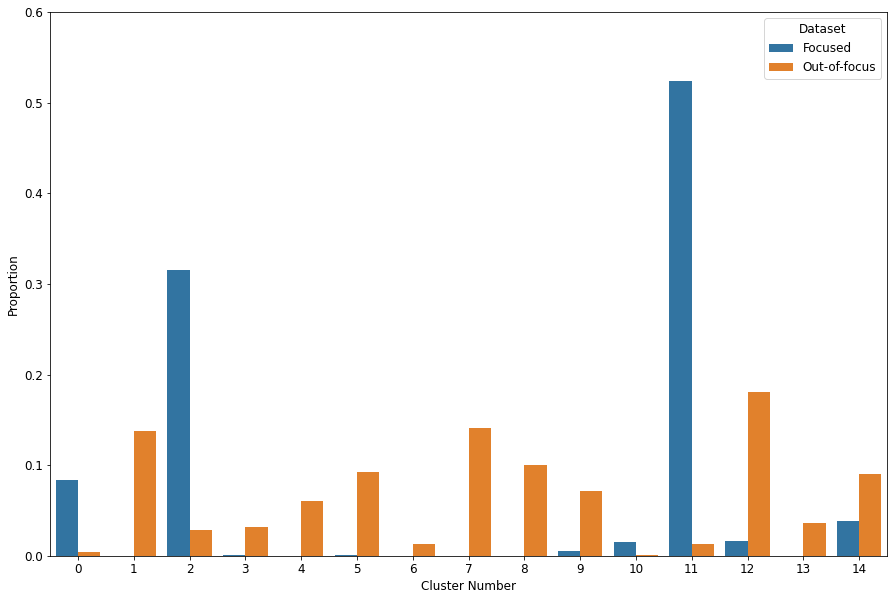

In [ ]:
plt.rcParams.update({'font.size':12} )
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x='Cluster Number', y='Proportion', hue='Dataset', data=clusters_bar_data)
plt.ylim(ymin=0, ymax=0.6)

Insights:

1. Clean melt pools stay close together, messy melt pool scattered around -- One Class Learning is a suitable candidate
2. Use KMeans clustering results as pre-sieved results.


In [ ]:
anomalies_build2 = []

for cluster in [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]:
  anomalies_build2.extend(list(training_df['ImageId'][(training_df['cluster']==cluster)&(training_df['isFocused']==1)].values))

In [ ]:
anomalies_imageId_build2 = pd.Series(anomalies_build2)


In [ ]:
attribute_df = pd.DataFrame(index=['spatterNum', 'spatterArea', 'spatterEccenticity', 'blobArea',
       'blobEccentricity'], columns=['cluster_0'])

# Loop thru the clusters
for cluster in range(optimal_k):
  attribute_df['cluster_{}'.format(cluster)] = Scaler.inverse_transform(kmeanModel.cluster_centers_[cluster])

attribute_df

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14
spatterNum,0.150898,2.721626,1.382503,3.507865,4.599567,3.463415,1.756381,7.933850,5.877722,5.172989,0.122105,0.156605,4.130139,4.763834,2.694753
spatterArea,0.736188,20.758621,8.658282,52.738202,22.978355,64.000000,140.078886,28.826106,25.653391,22.505211,1.160000,0.579624,24.030916,23.736166,17.981080
spatterEccenticity,0.003771,0.587324,0.737540,0.640378,0.589420,0.671343,0.710243,0.611374,0.577054,0.614395,0.028316,0.006321,0.588090,0.562939,0.607085
blobArea,182.107735,521.316054,193.866087,262.257303,715.578463,332.258405,387.932715,313.864381,707.685128,214.371822,55.117895,193.610260,257.246520,1120.835968,214.107215
blobEccentricity,0.653211,0.873328,0.847977,0.521977,0.599931,0.839081,0.794853,0.802523,0.883734,0.500774,0.096148,0.852368,0.854390,0.819454,0.676168


## Displaying the cluster Images

In [ ]:
X['imageId'] = training_df['imageId']

### Clusters 2 and 11

[Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, ''),
 Text(0.5, 1.0, '')]

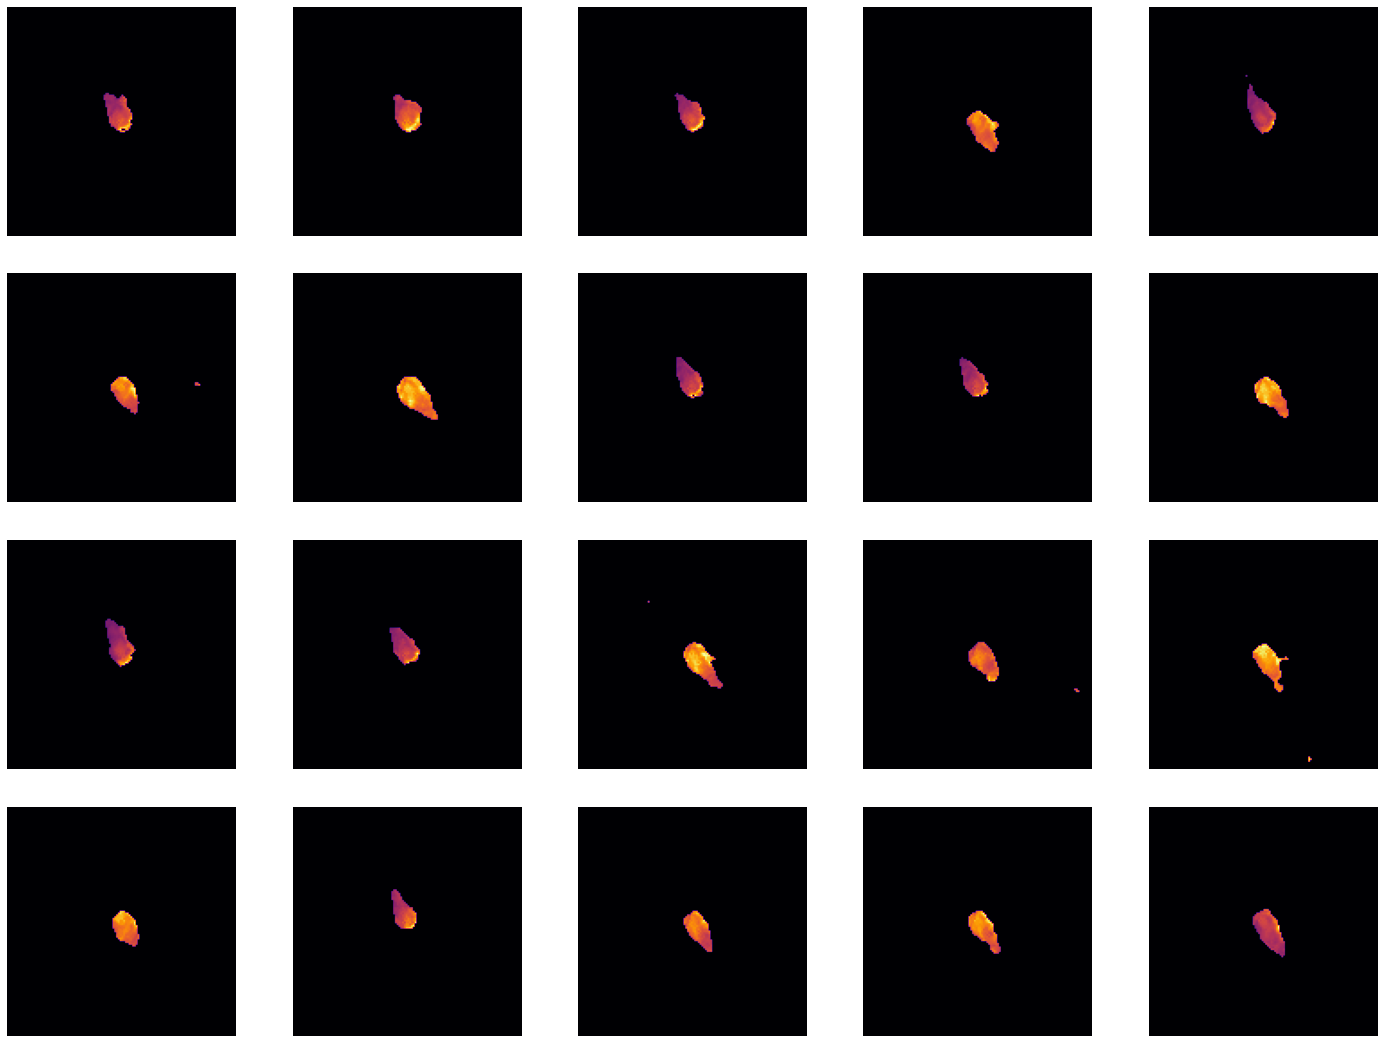

In [ ]:
plt.rcParams.update({'font.size':12})
imageIds = X['imageId'][(X['cluster'] == 2) & (X['isFocused'] == 1)].values
axes = show_images(imageIDs=imageIds[np.random.randint(0, len(imageIds), 20)], data=data)
_ = [ax.set_title('') for ax in axes]

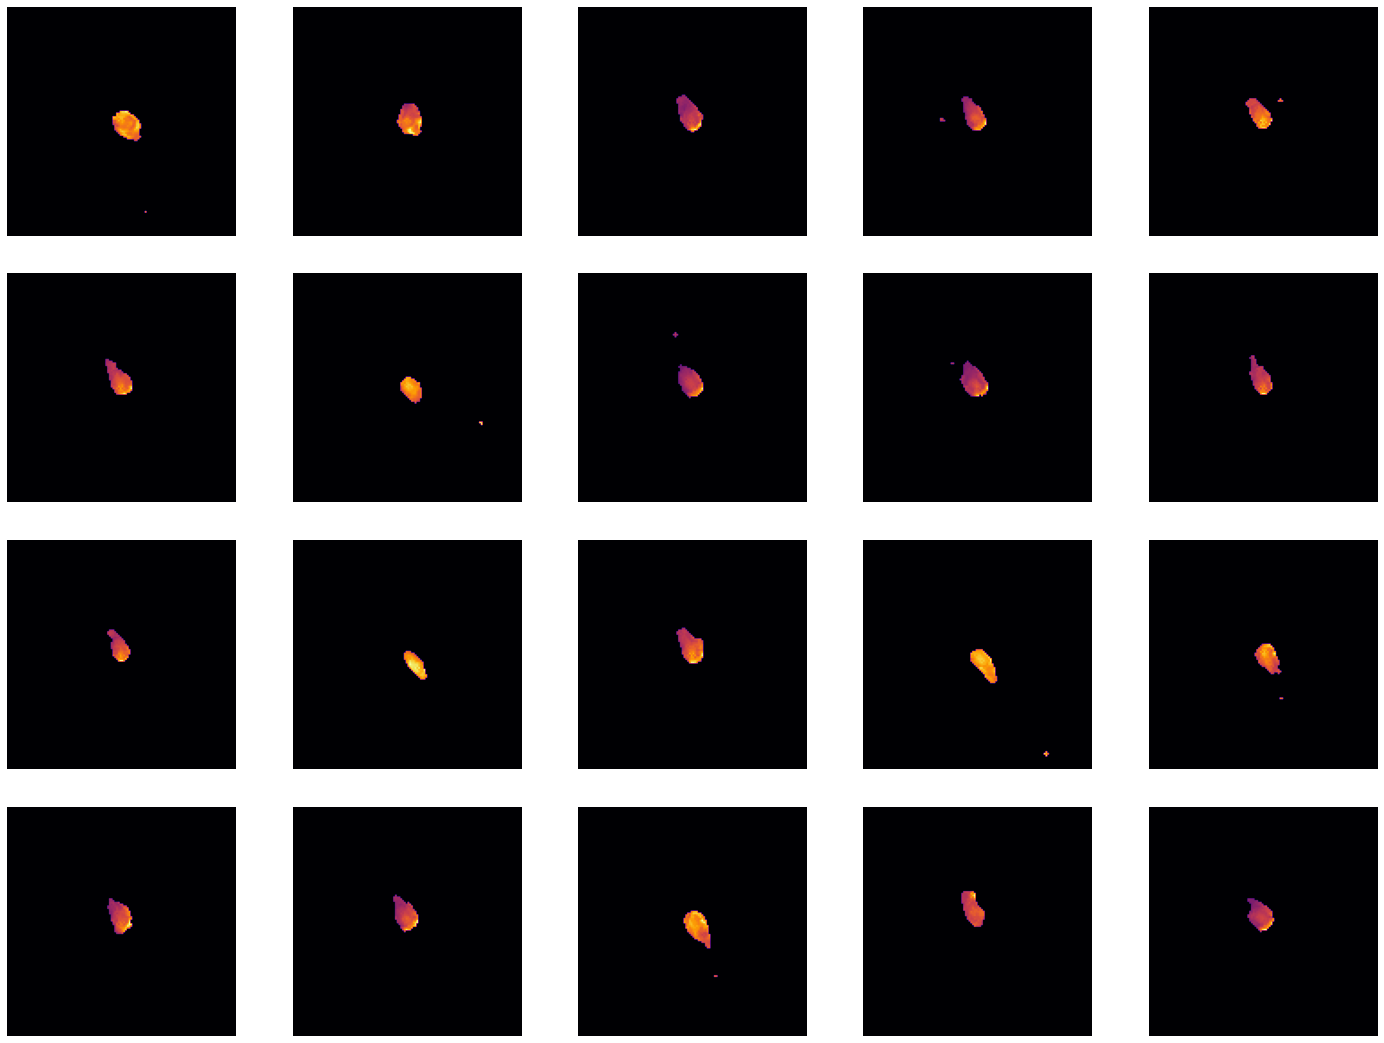

In [ ]:
imageIds = X['imageId'][(X['cluster'] == 11) & (X['isFocused'] == 1)].values
axes = show_images(imageIDs=imageIds[np.random.randint(0, len(imageIds), 20)], data=data)
_ = [ax.set_title('') for ax in axes]